#Install Dependencies

In [1]:
!pip install tensorflow opencv-python-headless matplotlib

In [2]:
import sys
print(sys.executable)

/Users/gabrielschull/anaconda3/envs/facialrecognition/bin/python


In [3]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [4]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
#Set GPU Memory Consumption Growth to avoid OOM errors -> wrong tensorflow version for this, not necessary though
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
#Make dirs
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [9]:
#Collecting labelled faces in the wild dataset at http://vis-www.cs.umass.edu/lfw/ (as gzipped tar file)

In [10]:
#uncompress Tar Labelled Faces in the Wild dataser
#!tar -xf lfw.tar

In [11]:
# Move lfw imgs to the following repo data/negative
#for directory in os.listdir('lfw'):
   # for file in os.listdir(os.path.join('lfw', directory)):
       # EX_PATH = os.path.join('lfw', directory, file)
       # NEW_PATH = os.path.join(NEG_PATH, file)
       # os.replace(EX_PATH, NEW_PATH)
    

In [12]:
import uuid

In [13]:
#Collect positive and anchor classes

cap = cv2.VideoCapture(0) #Establish a connection to the webcam
while cap.isOpened():
    ret, frame = cap.read() 
    
    #cut down to 250x250px frame
    frame = frame[250:250+250,475:475+250,:]

    key = cv2.waitKey(1) & 0XFF

    #collect anchors
    if key == ord('a'):
        #create unique filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
        break

    #collect positives
    if key == ord('p'):
        #create unique filepath
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
        break
        
        
    #show image back to screen
    cv2.imshow('Image Collection', frame)

    #breaking if q hit on keyboard after 1 ms
    if key == ord('q'):
        break
#release webcam & close the image show frame
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

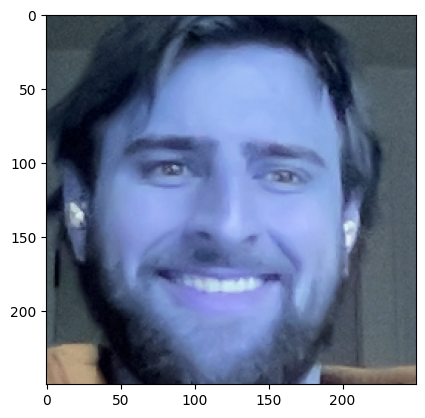

In [14]:
plt.imshow(frame)

In [15]:
#Load and preprocess Images
# get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2024-02-27 11:39:11.370047: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-27 11:39:11.370067: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-27 11:39:11.370071: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-27 11:39:11.370351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 11:39:11.370727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
dir_test = anchor.as_numpy_iterator()

In [17]:
print(dir_test.next())

b'data/anchor/8b722e14-d2a2-11ee-aa4a-563466da705a.jpg'


In [18]:
#Preprocessing - scale and resize

def preprocess(file_path):

    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps - resize image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # scale image to be between 0 and 1
    img = img / 255.0

    
    return img

In [19]:
img = preprocess('data/anchor/8de3e8e0-d2a2-11ee-aa4a-563466da705a.jpg')

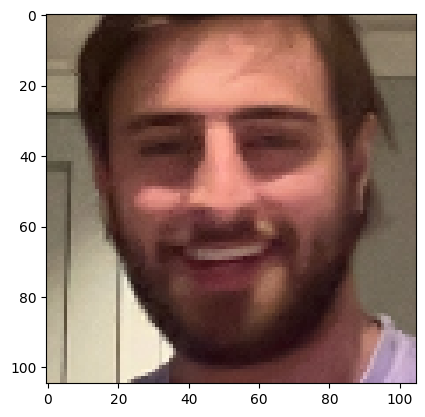

In [20]:
plt.imshow(img)

In [21]:
#dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [22]:
# Create labelled dataset
# (anchor, positive) =>  1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [23]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [24]:
samples = data.as_numpy_iterator()

In [25]:
example = samples.next()

In [26]:
example

(b'data/anchor/8e5e51a2-d2a2-11ee-aa4a-563466da705a.jpg',
 b'data/positive/0937db6e-d2a3-11ee-ab5a-563466da705a.jpg',
 1.0)

In [27]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
     return (preprocess(input_img), preprocess(validation_img), label)

In [28]:
preprocess_twin(*example)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.5690899 , 0.51026636, 0.42007026],
         [0.5696279 , 0.5147259 , 0.41276515],
         [0.570655  , 0.51575303, 0.4137922 ],
         ...,
         [0.53346   , 0.47463652, 0.3922836 ],
         [0.5239763 , 0.46515274, 0.3827998 ],
         [0.51073766, 0.46367884, 0.37740433]],
 
        [[0.5680606 , 0.50923705, 0.41904095],
         [0.58339345, 0.52483   , 0.4338536 ],
         [0.56916773, 0.5141123 , 0.41261175],
         ...,
         [0.50684273, 0.44801924, 0.3702148 ],
         [0.50506204, 0.44623852, 0.37172872],
         [0.4842204 , 0.43323997, 0.35873017]],
 
        [[0.5741586 , 0.5153351 , 0.42868707],
         [0.5703882 , 0.5115646 , 0.42466322],
         [0.56763595, 0.5105865 , 0.41506827],
         ...,
         [0.47817132, 0.41757375, 0.34838605],
         [0.46589303, 0.40529546, 0.3361078 ],
         [0.47704196, 0.42606157, 0.35509983]],
 
        ...,
 
        [[0.77297145, 0.7415989 

In [29]:
# Build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [30]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [32]:
train_samples = train_data.as_numpy_iterator()

In [33]:
train_sample = train_samples.next()

In [34]:
len(train_sample[0])

16

In [35]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [46]:
inp = Input(shape=(105,105,3), name='input_image')

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [49]:
m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

In [52]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

In [57]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

In [59]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [65]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [67]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [64]:
# Build embedding layer
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [68]:
model = make_embedding()

In [69]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

In [ ]:
# Build distance Layer
